# Friction models learning for Panda robot

In [45]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
import joblib
import pybullet
from pbdlib import LQR
from pbdlib.utils import get_canonical
import pandapybullet as ppb
import torch
import time
import GPy, GPyOpt
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Gather training data 
### Define random sine reference

Run a LQR using desired joint position and velocity to retrieve joint acceleration

In [47]:
N=20000
dt = 1e-3
T = N*dt
n_training = 5
n_testing = 0
n_tot = n_training + n_testing
joint_limits = np.empty([1,2])
joint_limits[0,0], joint_limits[0,1] = -np.pi, np.pi

# Trajectories specifications
specs = {'phi': {'low': -np.pi, 'high': np.pi}, 
         'A': {'low': -np.pi, 'high': np.pi},
         'f': {'low': 1/15, 'high': .5},
         'nb_parts': 100, 'margin': .2, 'safety': .9}

pendSim, pendReal = Robot(1, 1, dt, N), Robot(1, 1, dt, N)
pendSim.drawTrajectories(nb_traj=n_tot, q_limits=joint_limits, specs=specs)
pendReal.ref, pendReal.ddq = pendSim.ref, pendSim.desired_ddq
pendReal.nb_traj = pendSim.nb_traj

## Gather training data using CTC + PD

### Simulate using CTC + PD

In [50]:
log_control = np.empty(shape=[n_tot,N-1])
log_control_model = np.empty(shape=[n_tot,N-1])
log_q = np.empty(shape=[n_tot,N])
log_dq = np.empty(shape=[n_tot,N])
log_ddq = np.empty(shape=[n_tot,N])
pendulum = SimplePendulum(mass=1., 
                          length=1., 
                          time=np.arange(0,N*dt,dt),
                          k=0.1,
                          nu=5
                         )

Kp, Ki, Kd = 20, 1, 1
torque_limit = 40

for n in range(n_tot):
    pendulum.x = np.array([pendSim.ref[n,0,0],0,0])
    log_error = []
    sum_error = np.zeros(1)
    log_q[n,0] = pendulum.x[0]
    log_dq[n,0] = pendulum.x[1]
    log_ddq[n,0] = pendulum.x[2]
    
    for i in range(0, N-1):
        error_q = pendSim.ref[n,0,i] - pendulum.x[0]
        error_dq = pendSim.ref[n,1,i] - pendulum.x[1]

    #   Computed Torque Control
#         control_input = pendulum.CTC(pendSim.desired_ddq[n,:,i],
#                                     -( Kp * error_q + Ki * sum_error + Kd * error_dq )
#                                    )
        control_input = pendulum.CTC(pendSim.desired_ddq[n,:,i],
                                    -( Kp * error_q + Ki * sum_error + Kd * error_dq ),
                                    friction=False
                                   )
        if control_input > torque_limit:
            control_input = torque_limit
        elif control_input < -torque_limit:
            control_input = torque_limit

        pendulum.x[:2,None] = RK4(pendulum.Physics,
                                  pendulum.x[:2,None], 
                                  control_input,
                                  pendulum.T, 
                                  type='controller-step-by-step'
                                 ) # Simulation
        pendulum.x[2] = pendulum.Physics(pendulum.x[:2],control_input)[1]

        log_error.append(np.copy(error_q))
        log_q[n,i] = pendulum.x[0]
        log_dq[n,i] = pendulum.x[1]
        log_ddq[n,i] = pendulum.x[2]
        log_control[n,i] = control_input
    #     time.sleep(dt)
        sum_error += error_q*dt
log_q = log_q[:,:-1]
log_dq = log_dq[:,:-1]

## Store data in state-space form

### Data for bad model (simulated)

In [49]:
pendSim.toStateSpace(log_q.copy(), log_dq.copy(), log_control.copy())

### Data for true dynamics (observed)

In [51]:
pendReal.toStateSpace(log_q.copy(), log_dq.copy(), log_control.copy())

### Difference dynamics
Here, the difference between the data simulated with the bad model with the suitable controller and the data gathered using the same controller but on the true system dynamics (which have synthetically been altered) is computed. <br><br>
$$ \delta X = X_0 - X_{model}$$ <br><br>
After that, the same algorithm leveraging HAVOK will be employed to retrieve a dynamical expression of the dynamical discrepancy.

In [52]:
delta_U = pendReal.U - pendSim.U
delta_X = pendReal.X - pendSim.X

### Plot for bad model (but rightly calibrated controller)

(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

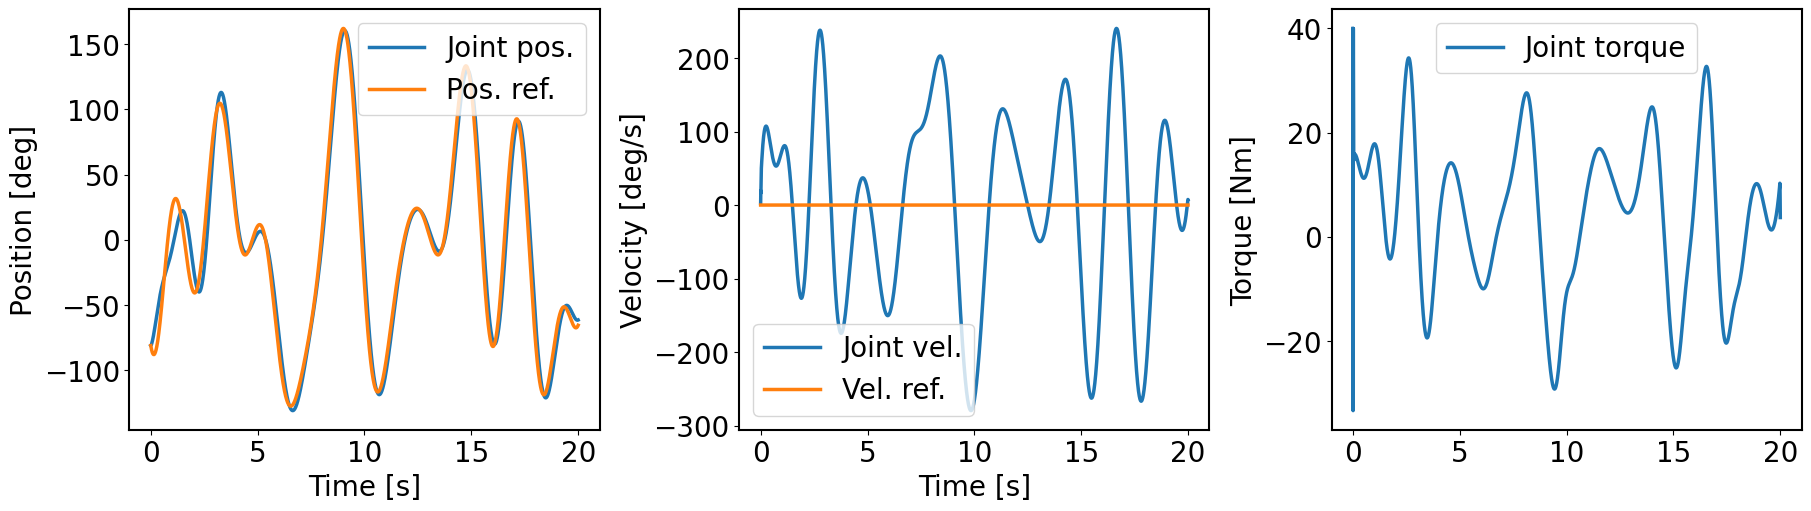

In [53]:
traj = 0
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize=(18,5))

ax[0].plot(pendSim.T[:-1], rad2deg(pendSim.X[traj,0,:]), label='Joint pos.')
ax[0].plot(pendSim.T[:], rad2deg(pendSim.ref[traj,0,:]), label='Pos. ref.')
ax[1].plot(pendSim.T[:-1], rad2deg(pendSim.X[traj,1,:]), label='Joint vel.')
ax[1].plot(pendSim.T[:], rad2deg(pendSim.ref[traj,1,:]), label='Vel. ref.')
ax[2].plot(pendSim.T[:-1], pendSim.U[traj,:], label='Joint torque')
ax[0].set_ylabel('Position [deg]'), ax[1].set_ylabel('Velocity [deg/s]'), ax[2].set_ylabel('Torque [Nm]')
ax[0].legend(), ax[1].legend(), ax[2].legend()
    
ax[0].set_xlabel('Time [s]'), ax[1].set_xlabel('Time [s]')

### Plot for true dynamics with wrong controller

(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

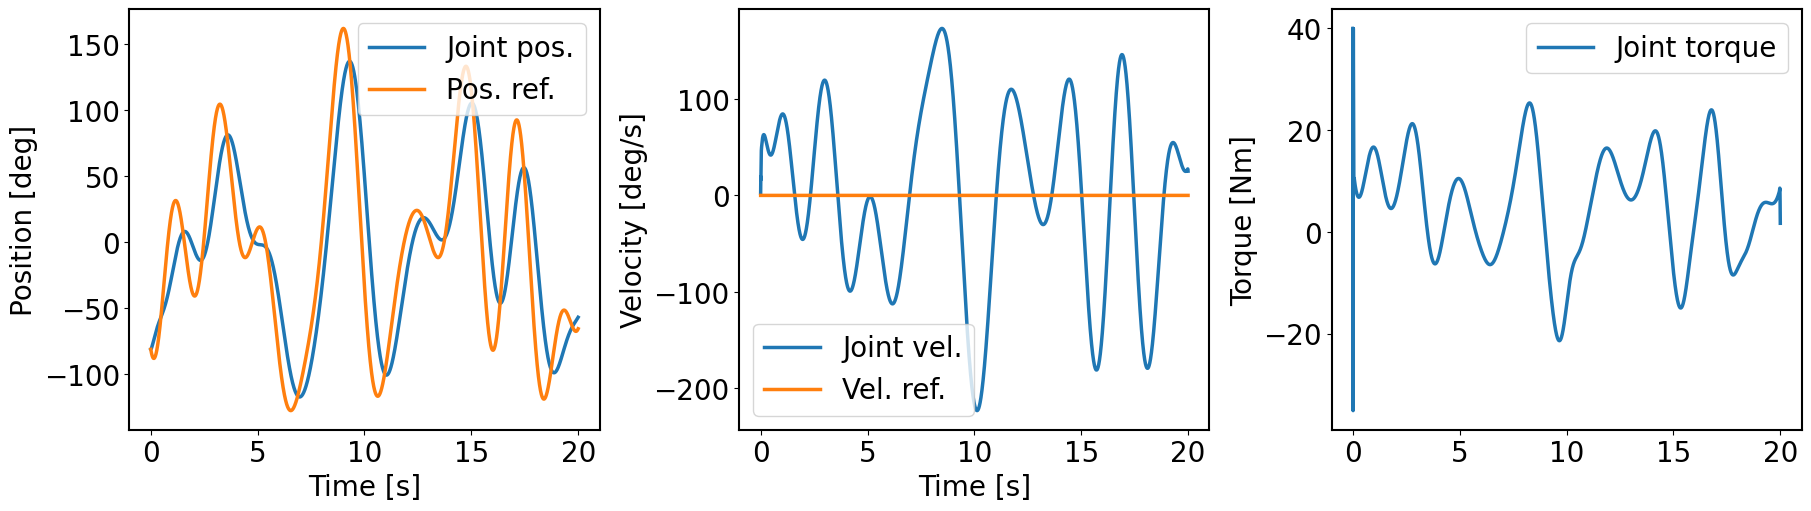

In [54]:
traj = 0
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize=(18,5))

ax[0].plot(pendReal.T[:-1], rad2deg(pendReal.X[traj,0,:]), label='Joint pos.')
ax[0].plot(pendReal.T, rad2deg(pendReal.ref[traj,0,:]), label='Pos. ref.')
ax[1].plot(pendReal.T[:-1], rad2deg(pendReal.X[traj,1,:]), label='Joint vel.')
ax[1].plot(pendReal.T, rad2deg(pendReal.ref[traj,1,:]), label='Vel. ref.')
ax[2].plot(pendReal.T[:len(pendReal.T)-1], pendReal.U[traj,:], label='Joint torque')
ax[0].set_ylabel('Position [deg]'), ax[1].set_ylabel('Velocity [deg/s]'), ax[2].set_ylabel('Torque [Nm]')
ax[0].legend(), ax[1].legend(), ax[2].legend()
    
ax[0].set_xlabel('Time [s]'), ax[1].set_xlabel('Time [s]')

### Plot residual dynamics

(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

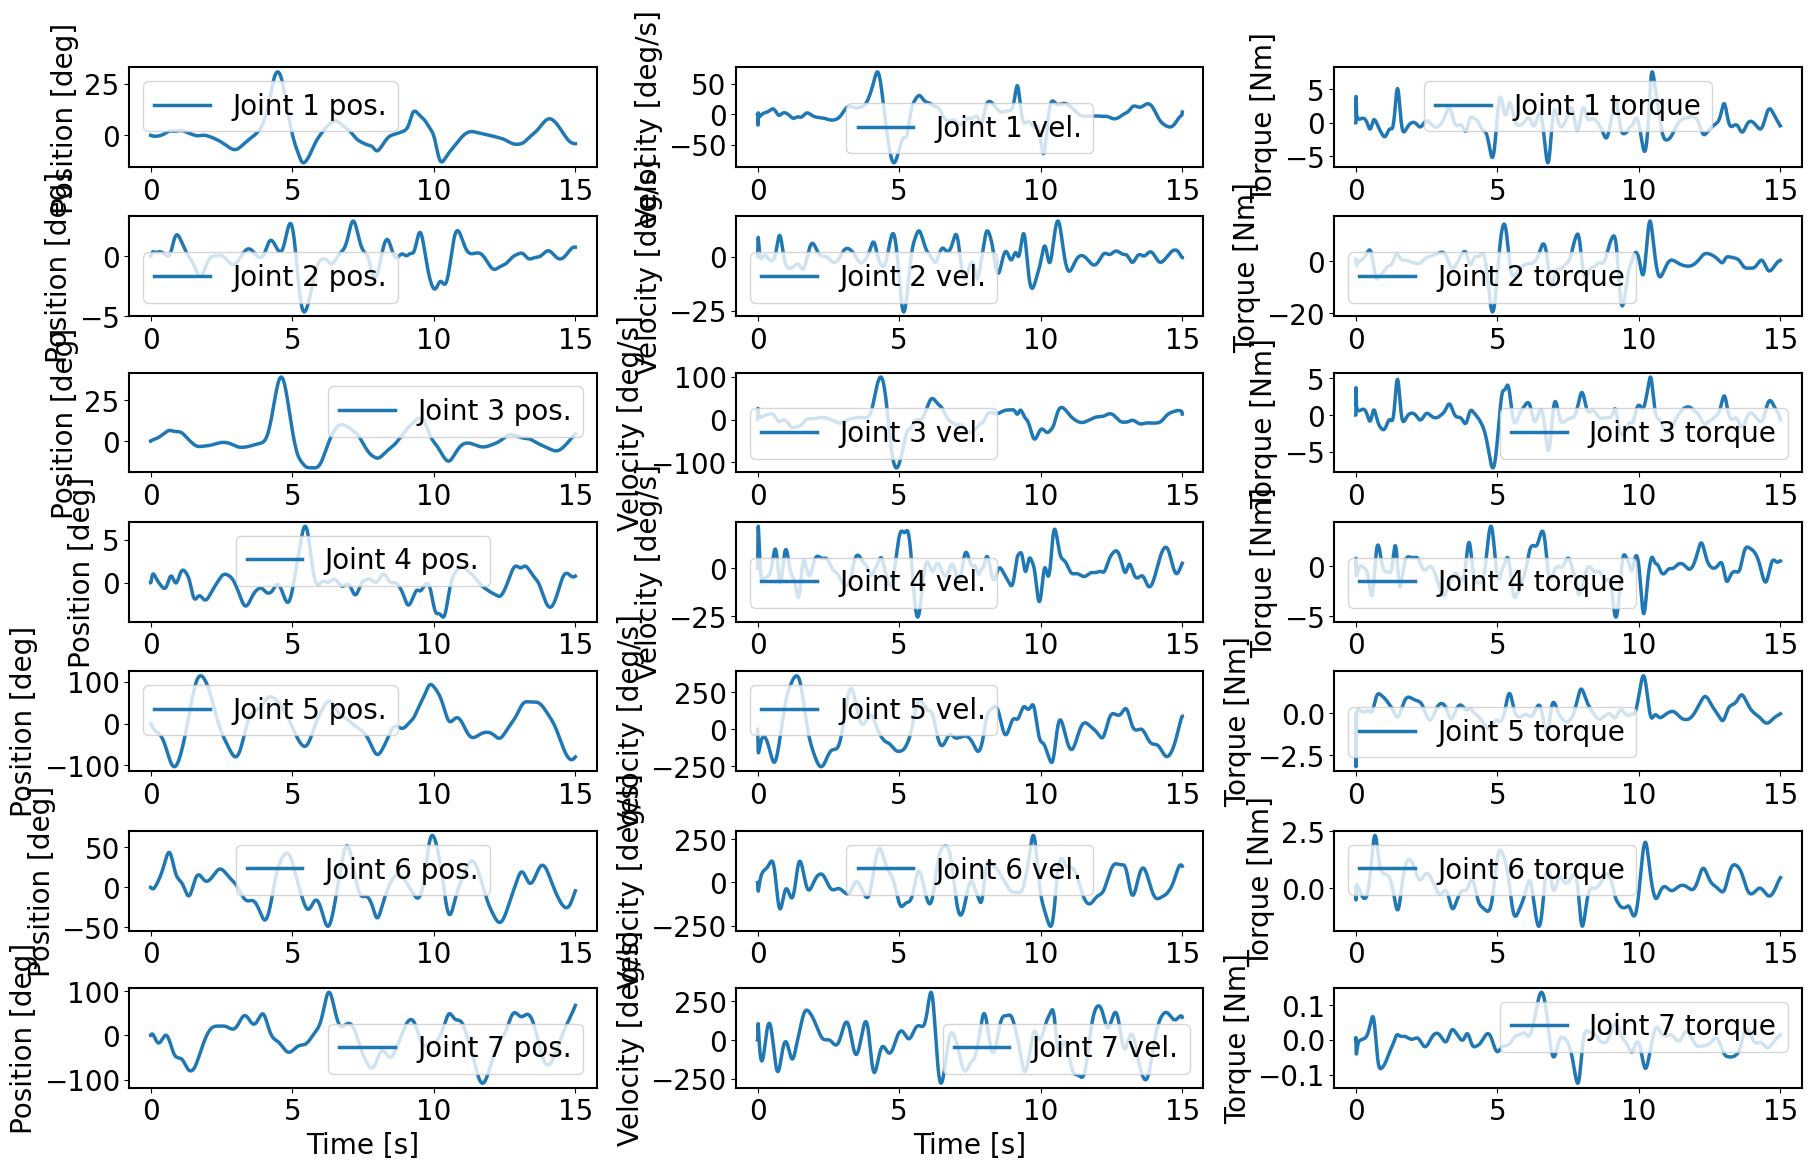

In [19]:
traj = 0
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(7, 3, constrained_layout = True, figsize=(18,11))

for i in range(7):
    
    ax[i,0].plot(pandaRobot2.T, rad2deg(delta_X[traj,i,:]), label='Joint '+str(i+1)+' pos.')
    ax[i,1].plot(pandaRobot2.T, rad2deg(delta_X[traj,i+7,:]), label='Joint '+str(i+1)+' vel.')
    ax[i,2].plot(pandaRobot2.T[:-1], delta_U[traj,i,:], label='Joint '+str(i+1)+' torque')
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

## Model training 

In [55]:
nb_train, nb_test = 15000, 5000 # train-test ratio of 2

### Using *GPyOpt*

In [27]:
traj_ratio = .05
n_low, n_high = 40, 150
d_low, d_high = 1, np.int((1-traj_ratio)/n_high*nb_train)
ref_zeros = np.zeros([2,nb_train-1])
nb_train, nb_test = 15000, 5000 # train-test ratio of 2

domain = [
    {'name': 'dimension', 'type': 'discrete', 'domain': np.arange(1,15,1)},
    {'name': 'nb_traj', 'type': 'discrete', 'domain': np.arange(n_low,n_high,1)},
    {'name': 'nb_delays', 'type': 'discrete', 'domain': np.arange(d_low,d_high,1)}
]

print('delay max : ',np.int((1-traj_ratio)/n_high*nb_train))
print('points min : ',nb_train- d_high*n_high)

loss_prediction_train = np.empty(shape=[n_training])
loss_prediction_test = np.empty(shape=[n_training])
loss_corr = np.empty(shape=[n_training])
loss_LQR = np.empty(shape=[n_training])

N = pendSim.X.shape[2]

def loss(space):
    # Model parameters
    n_params = space.shape[0] # If train by batch
    s = np.int(space[0,0])
    n = np.int(space[0,1])
    d = np.int(space[0,2])
#     nx = np.int(space[0,0])
#     nu = np.int(space[0,1])
#     d = np.int(space[0,2])
    
    timing = np.empty([2,n_training])
    
    for fold in range(n_training):
        timing[0,fold] = time.time() # HAVOK computation time
        
        # TRAINING #####################################################
        model = HAVOK(delta_X[fold,:,:nb_train], # state-wise difference
                      torch.cat((pendSim.X[fold,:,:nb_train-1], # Exogenous inputs vector
                                 pendSim.U[fold,None,:nb_train-1],
                                 delta_U[fold,None,:nb_train-1]),axis=0),
#                                  delta_U[fold,None,:nb_train-1]),axis=0), 
                      mode='ELQR form',
                      nb_U=4,
                      nb_U_ex=3
                     )
        model.HANKEL(n, d)
        model.SVD(s)
        model.LS(s,rcond=0)
        
        timing[0,fold] = time.time() - timing[0,fold]  
        timing[1,fold] = time.time() # Simulation time computation
        # TESTING ######################################################
        model.Simulate(X0=delta_X[fold,:,0],
                       horizon=nb_train,
                       U=torch.cat((pendSim.X[fold,:,:nb_train],
                                    pendSim.U[fold,None,:nb_train],
#                                     pendReal.U[fold,None,:nb_train]),axis=0).to(torch.float)
                                    delta_U[fold,None,:nb_train]),axis=0).to(torch.float)
                      )
        
        loss_prediction_train[fold] = model.RMSE(X_pred=model.X_prediction,
                                           X_true=delta_X[fold,:,:nb_train])
        model.Simulate(X0=delta_X[fold,:,nb_train],
                       horizon=nb_test,
                       U=torch.cat((pendSim.X[fold,:,nb_train:],
                                    pendSim.U[fold,None,nb_train:],
#                                     pendReal.U[fold,None,nb_train:]),axis=0).to(torch.float)
                                    delta_U[fold,None,nb_train:]),axis=0).to(torch.float)
                      )
        loss_prediction_test[fold] = model.RMSE(X_pred=model.X_prediction[:,:-1],
                                           X_true=delta_X[fold,:,nb_train:])
        
        timing[1,fold] = time.time() - timing[1,fold]  
        
    loss_pred_train_sum = np.mean(loss_prediction_train)
    loss_pred_test_sum = np.mean(loss_prediction_test)
    loss = loss_pred_train_sum + loss_pred_test_sum
    avg_time = [timing[0,:].sum()/n_training,timing[1,:].sum()/n_training]
    
    if np.isnan(loss) or np.isinf(loss):
        loss = 1e10
        
#     print('Total loss : '+str(loss)+' Loss sim. : '+str(loss_traj_sum)+
#           ', s :'+str(s)+', n :'+str(n)+', d : '+str(d))
    print('Total loss : '+str(loss)+' Loss train. : '+str(loss_pred_train_sum)+
          ' Loss test. : '+str(loss_pred_test_sum)+
          ', r :'+str(s)+', n :'+str(n)+', d : '+str(d))
    print('Avg computation time for HAVOK : '+str(avg_time[0])+' [s], for sim. : '+str(avg_time[1])+' [s]')
    
    return loss

max_iter = 1000
batch_size = 6
num_cores = 6

opt = GPyOpt.methods.BayesianOptimization(f = loss,            # function to optimize       
                                          domain = domain,         # box-constraints of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = 0.2)     # Exploration exploitation
 

opt.run_optimization(max_iter)

delay max :  95
points min :  750
Total loss : 10000000000.0 Loss train. : inf Loss test. : 8990889444.704952, r :10, n :103, d : 8
Avg computation time for HAVOK : 0.8790211200714111 [s], for sim. : 0.8619222640991211 [s]
Total loss : 76426295305.64708 Loss train. : 76426264560.61992 Loss test. : 30745.027154541014, r :3, n :77, d : 33
Avg computation time for HAVOK : 2.5674112319946287 [s], for sim. : 0.8841437816619873 [s]
Total loss : 2134678195248.4792 Loss train. : 2134678177756.439 Loss test. : 17492.040295410156, r :2, n :105, d : 11
Avg computation time for HAVOK : 0.9118385791778565 [s], for sim. : 0.8917641639709473 [s]
Total loss : 615856.2747177124 Loss train. : 615501.4147460938 Loss test. : 354.85997161865237, r :4, n :93, d : 47
Avg computation time for HAVOK : 0.4737968921661377 [s], for sim. : 0.8913846015930176 [s]
Total loss : 3701.6844909667966 Loss train. : 3604.8194213867187 Loss test. : 96.86506958007813, r :9, n :84, d : 46
Avg computation time for HAVOK : 0.48

## LQR control of the Panda robot
### Model prediction capabilities in training

tensor(6.3853)


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

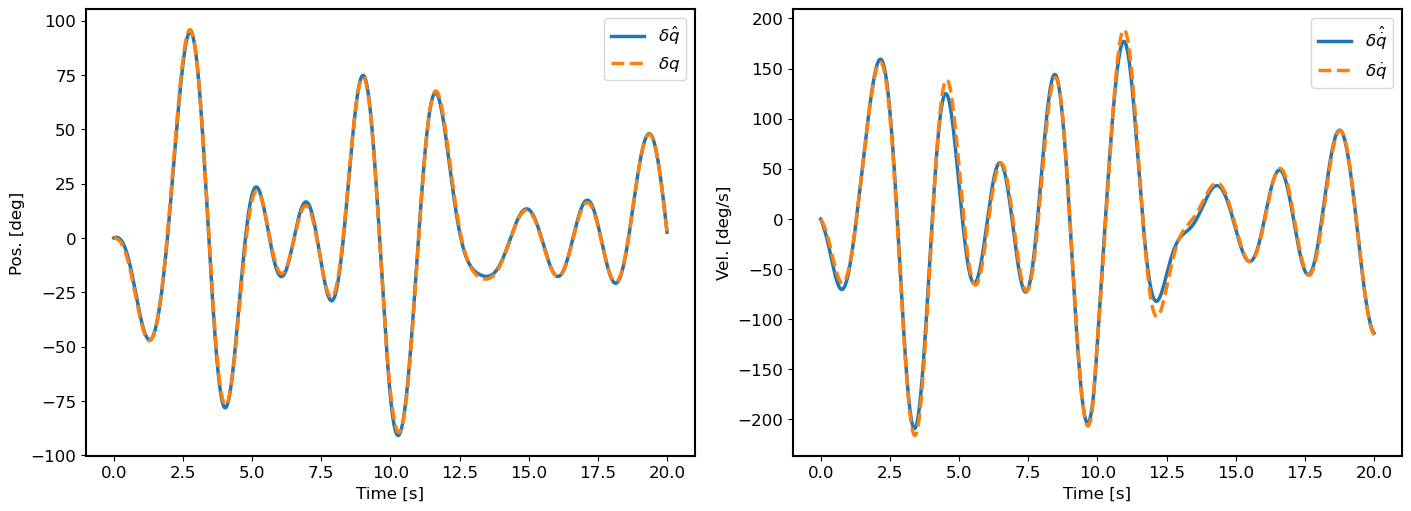

In [59]:
# Train linear model
traj = 0

n = 150
r = 2
d = 1

model = HAVOK(delta_X[traj,:,:nb_train], # state-wise difference
              torch.cat((pendSim.X[traj,:,:nb_train-1],
                         pendSim.U[traj,None,:nb_train-1],
                         delta_U[traj,None,:nb_train-1]),axis=0), # model predicted states
              mode='ELQR form',
              nb_U=4,
              nb_U_ex=3
             )
# model = HAVOK(pandaRobot.X[traj,:,:nb_train], # state-wise difference
#               pandaRobot.U[traj,:,nb_train-1], # model predicted states
#               mode='prediction'
#              )
model.HANKEL(n, d)
model.SVD(r)
model.LS(r,rcond=0)
# model.Simulate(delta_X[traj,:,0],
#                horizon=nb_train,
#                U=torch.cat((pendSim.X[traj,:,:nb_train-1],
#                           pendSim.U[traj,None,:nb_train-1],
#                           delta_U[traj,None,:nb_train-1]),axis=0),
#                )
traj=2
model.Simulate(delta_X[traj,:,0],
               horizon=nb_test + nb_train-1,
               U=torch.cat((pendSim.X[traj,:,:],
                            pendSim.U[traj,None,:],
                            delta_U[traj,None,:]),axis=0),
               )
loss_traj = model.RMSE(X_true=delta_X[traj],
                       X_pred=model.X_prediction 
                      )
print(loss_traj)
# print(loss_model)

# plt.rcParams['font.size'] = 20
# fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize=(18,8))

# figA = snb.heatmap(model.A,cmap='Reds',ax=ax[0])
# figB = snb.heatmap(model.B,cmap='Reds',ax=ax[1])

plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize=(14,5))
    
# ax[0].plot(pendReal.T[:nb_train], rad2deg(model.X_prediction[0,:]), label=r'$\delta \hat{q}$')
# ax[0].plot(pendReal.T[:nb_train], rad2deg(delta_X[traj,0,:nb_train]), label=r'$\delta q$', linestyle='dashed')
# ax[1].plot(pendReal.T[:nb_train], rad2deg(model.X_prediction[1,:]), label=r'$\delta \hat{\dot{q}}$')
# ax[1].plot(pendReal.T[:nb_train], rad2deg(delta_X[traj,1,:nb_train]), label=r'$\delta \dot{q}$', linestyle='dashed')

ax[0].plot(pendReal.T[:-1], rad2deg(model.X_prediction[0,:]), label=r'$\delta \hat{q}$')
ax[0].plot(pendReal.T[:-1], rad2deg(delta_X[traj,0,:]), label=r'$\delta q$', linestyle='dashed')
ax[1].plot(pendReal.T[:-1], rad2deg(model.X_prediction[1,:]), label=r'$\delta \hat{\dot{q}}$')
ax[1].plot(pendReal.T[:-1], rad2deg(delta_X[traj,1,:]), label=r'$\delta \dot{q}$', linestyle='dashed')

ax[0].set_ylabel('Pos. [deg]'), ax[1].set_ylabel('Vel. [deg/s]')
ax[0].legend(), ax[1].legend()
    
ax[0].set_xlabel('Time [s]'), ax[1].set_xlabel('Time [s]')

### Use Extended LQR to correct trajectory

(Text(0.5, 262.7781111111112, 'Time [s]'),
 Text(0.5, 262.7781111111112, 'Time [s]'))

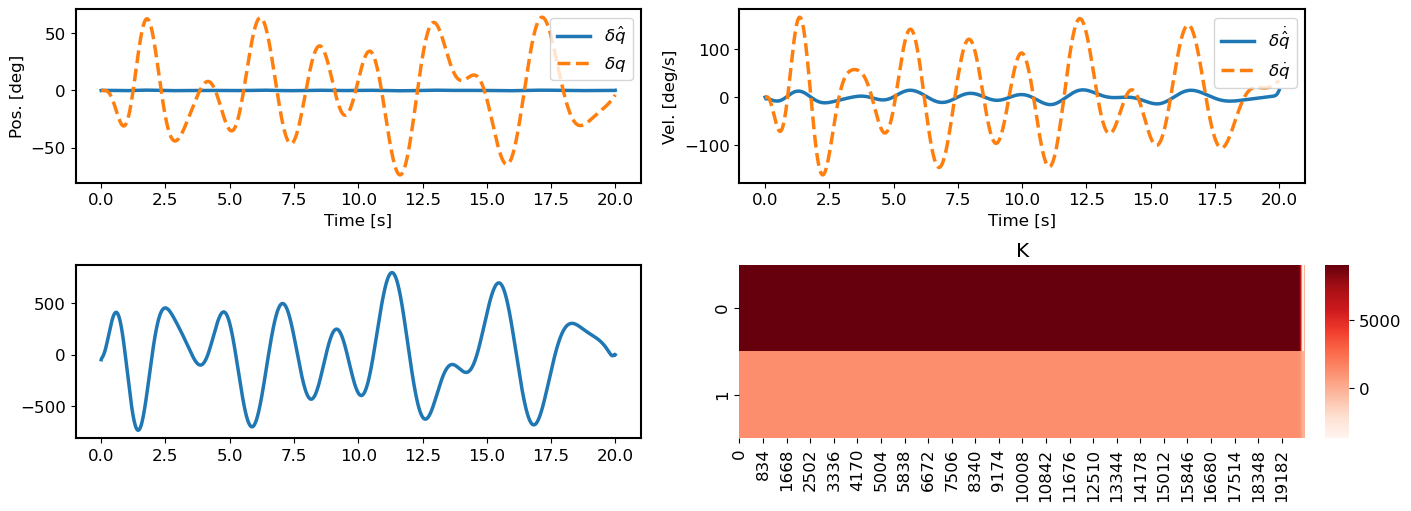

In [92]:
# Train linear model #######################################
traj = 1
# Correct trajectories with ELQR ############################
u_d = torch.cat((pendSim.X[traj,:,:],
                 pendSim.U[traj,None,:]),axis=0)
model.ConstructLQR(x_std=1e6*np.array([1,0]),
                   u_std=-2.,
                   dt=pendSim.dt,
                   horizon=pendReal.N,
                   mode='ELQR',
                   u_d=u_d,
                   Bd=model.Bd
                  )
model.LQR_simulate(delta_X[traj,:,0].numpy(),
                   mode='ELQR', 
                   u_d=u_d,
                   Bd=model.Bd
                  )

plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(2, 2, constrained_layout = True, figsize=(14,5))

ax[0,0].plot(pendReal.T[:-1], rad2deg(model.LQR_X[0,:]), label=r'$\delta \hat{q}$')
ax[0,0].plot(pendReal.T[:-1], rad2deg(delta_X[traj,0,:]), label=r'$\delta q$', linestyle='dashed')
ax[0,1].plot(pendReal.T[:-1], rad2deg(model.LQR_X[1,:]), label=r'$\delta \dot{\hat{q}}$')
ax[0,1].plot(pendReal.T[:-1], rad2deg(delta_X[traj,1,:]), label=r'$\delta \dot{q}$', linestyle='dashed')
ax[1,0].plot(pendReal.T[:-2], model.LQR_U[0,:,0], label=r'$u_{corr}$')
ax[1,1].set_title('K')
snb.heatmap((np.array(model.LQR.K)[:,0,:] @ model.pinvC).T,cmap='Reds')

ax[0,0].set_ylabel('Pos. [deg]'), ax[0,1].set_ylabel('Vel. [deg/s]')
ax[0,0].legend(), ax[0,1].legend()
    
ax[0,0].set_xlabel('Time [s]'), ax[0,1].set_xlabel('Time [s]')

In [88]:
np.array(model.LQR.K).shape

(19998, 1, 2)

### Corrected trajectories

(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

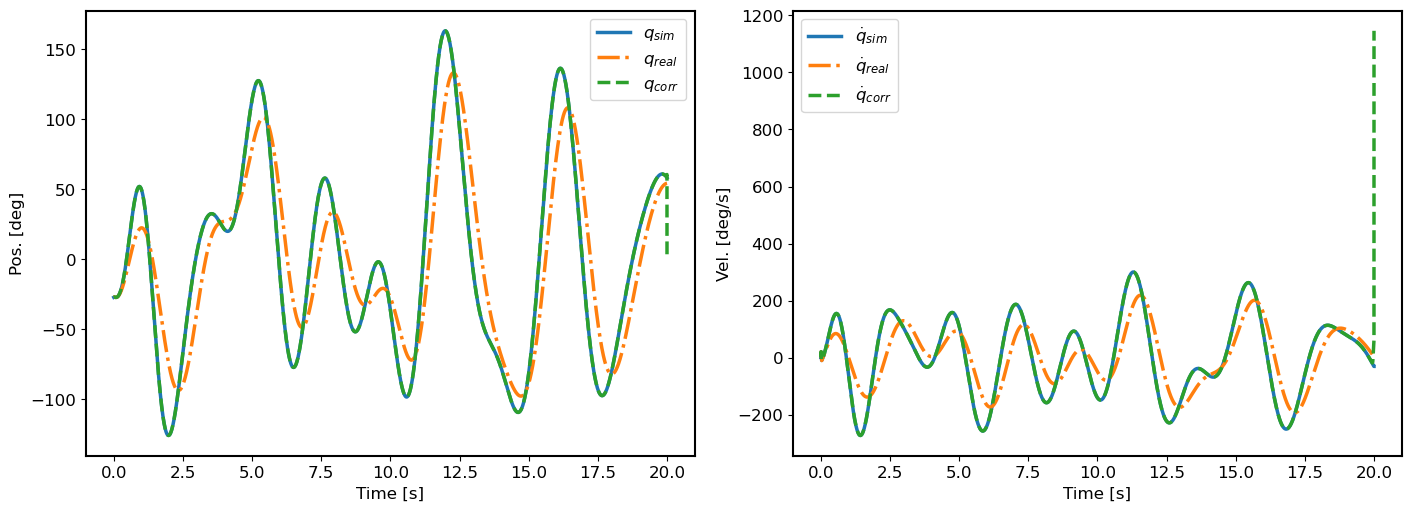

In [93]:
log_control = np.empty(shape=[N-1])
log_control_model = np.empty(shape=[N-1])
log_q = np.empty(shape=[N])
log_dq = np.empty(shape=[N])
log_ddq = np.empty(shape=[N])
pendulum = SimplePendulum(mass=1., 
                          length=1., 
                          time=np.arange(0,N*dt,dt),
                          k=0.1,
                          nu=5
                         )

Kp, Ki, Kd = 20, 1, 1
K = (np.array(model.LQR.K)[:,0,:] @ model.pinvC)
torque_limit = 40

pendulum.x = np.array([pendSim.ref[traj,0,0],0,0])
log_error = []
sum_error = np.zeros(1)
log_q[0] = pendulum.x[0]
log_dq[0] = pendulum.x[1]
log_ddq[0] = pendulum.x[2]

for i in range(0, N-2):
    error_q = pendSim.ref[traj,0,i] - pendulum.x[0]
    error_dq = pendSim.ref[traj,1,i] - pendulum.x[1]

#   Computed Torque Control
#         control_input = pendulum.CTC(pendSim.desired_ddq[n,:,i],
#                                     -( Kp * error_q + Ki * sum_error + Kd * error_dq )
#                                    )
    control_input = pendulum.CTC(pendSim.desired_ddq[traj,:,i],
                                 -( Kp * error_q + Ki * sum_error + Kd * error_dq ),
                                 friction=False
                                ) - K[i,:] @ (pendulum.x[:2] - pendSim.X[traj,:,i].numpy())
    
    if control_input > torque_limit:
        control_input = torque_limit
    elif control_input < -torque_limit:
        control_input = torque_limit

    pendulum.x[:2,None] = RK4(pendulum.Physics,
                              pendulum.x[:2,None], 
                              control_input,
                              pendulum.T, 
                              type='controller-step-by-step'
                             ) # Simulation
    pendulum.x[2] = pendulum.Physics(pendulum.x[:2],control_input)[1]

    log_error.append(np.copy(error_q))
    log_q[i] = pendulum.x[0]
    log_dq[i] = pendulum.x[1]
    log_ddq[i] = pendulum.x[2]
    log_control[i] = control_input

    sum_error += error_q*dt
log_q = log_q[:-1]
log_dq = log_dq[:-1]

plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize=(14,5))

ax[0].plot(pendReal.T[:-1], rad2deg(pendSim.X[traj,0,:]), label=r'$q_{sim}$')
ax[0].plot(pendReal.T[:-1], rad2deg(pendReal.X[traj,0,:]), label=r'$q_{real}$', linestyle='dashdot')
ax[0].plot(pendReal.T[:-1], rad2deg(log_q[:]), label=r'$q_{corr}$', linestyle='dashed')
ax[1].plot(pendReal.T[:-1], rad2deg(pendSim.X[traj,1,:]), label=r'$\dot{q}_{sim}$')
ax[1].plot(pendReal.T[:-1], rad2deg(pendReal.X[traj,1,:]), label=r'$\dot{q}_{real}$', linestyle='dashdot')
ax[1].plot(pendReal.T[:-1], rad2deg(log_dq[:]), label=r'$\dot{q}_{corr}$', linestyle='dashed')

ax[0].set_ylabel('Pos. [deg]'), ax[1].set_ylabel('Vel. [deg/s]')
ax[0].legend(), ax[1].legend()
    
ax[0].set_xlabel('Time [s]'), ax[1].set_xlabel('Time [s]')

(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

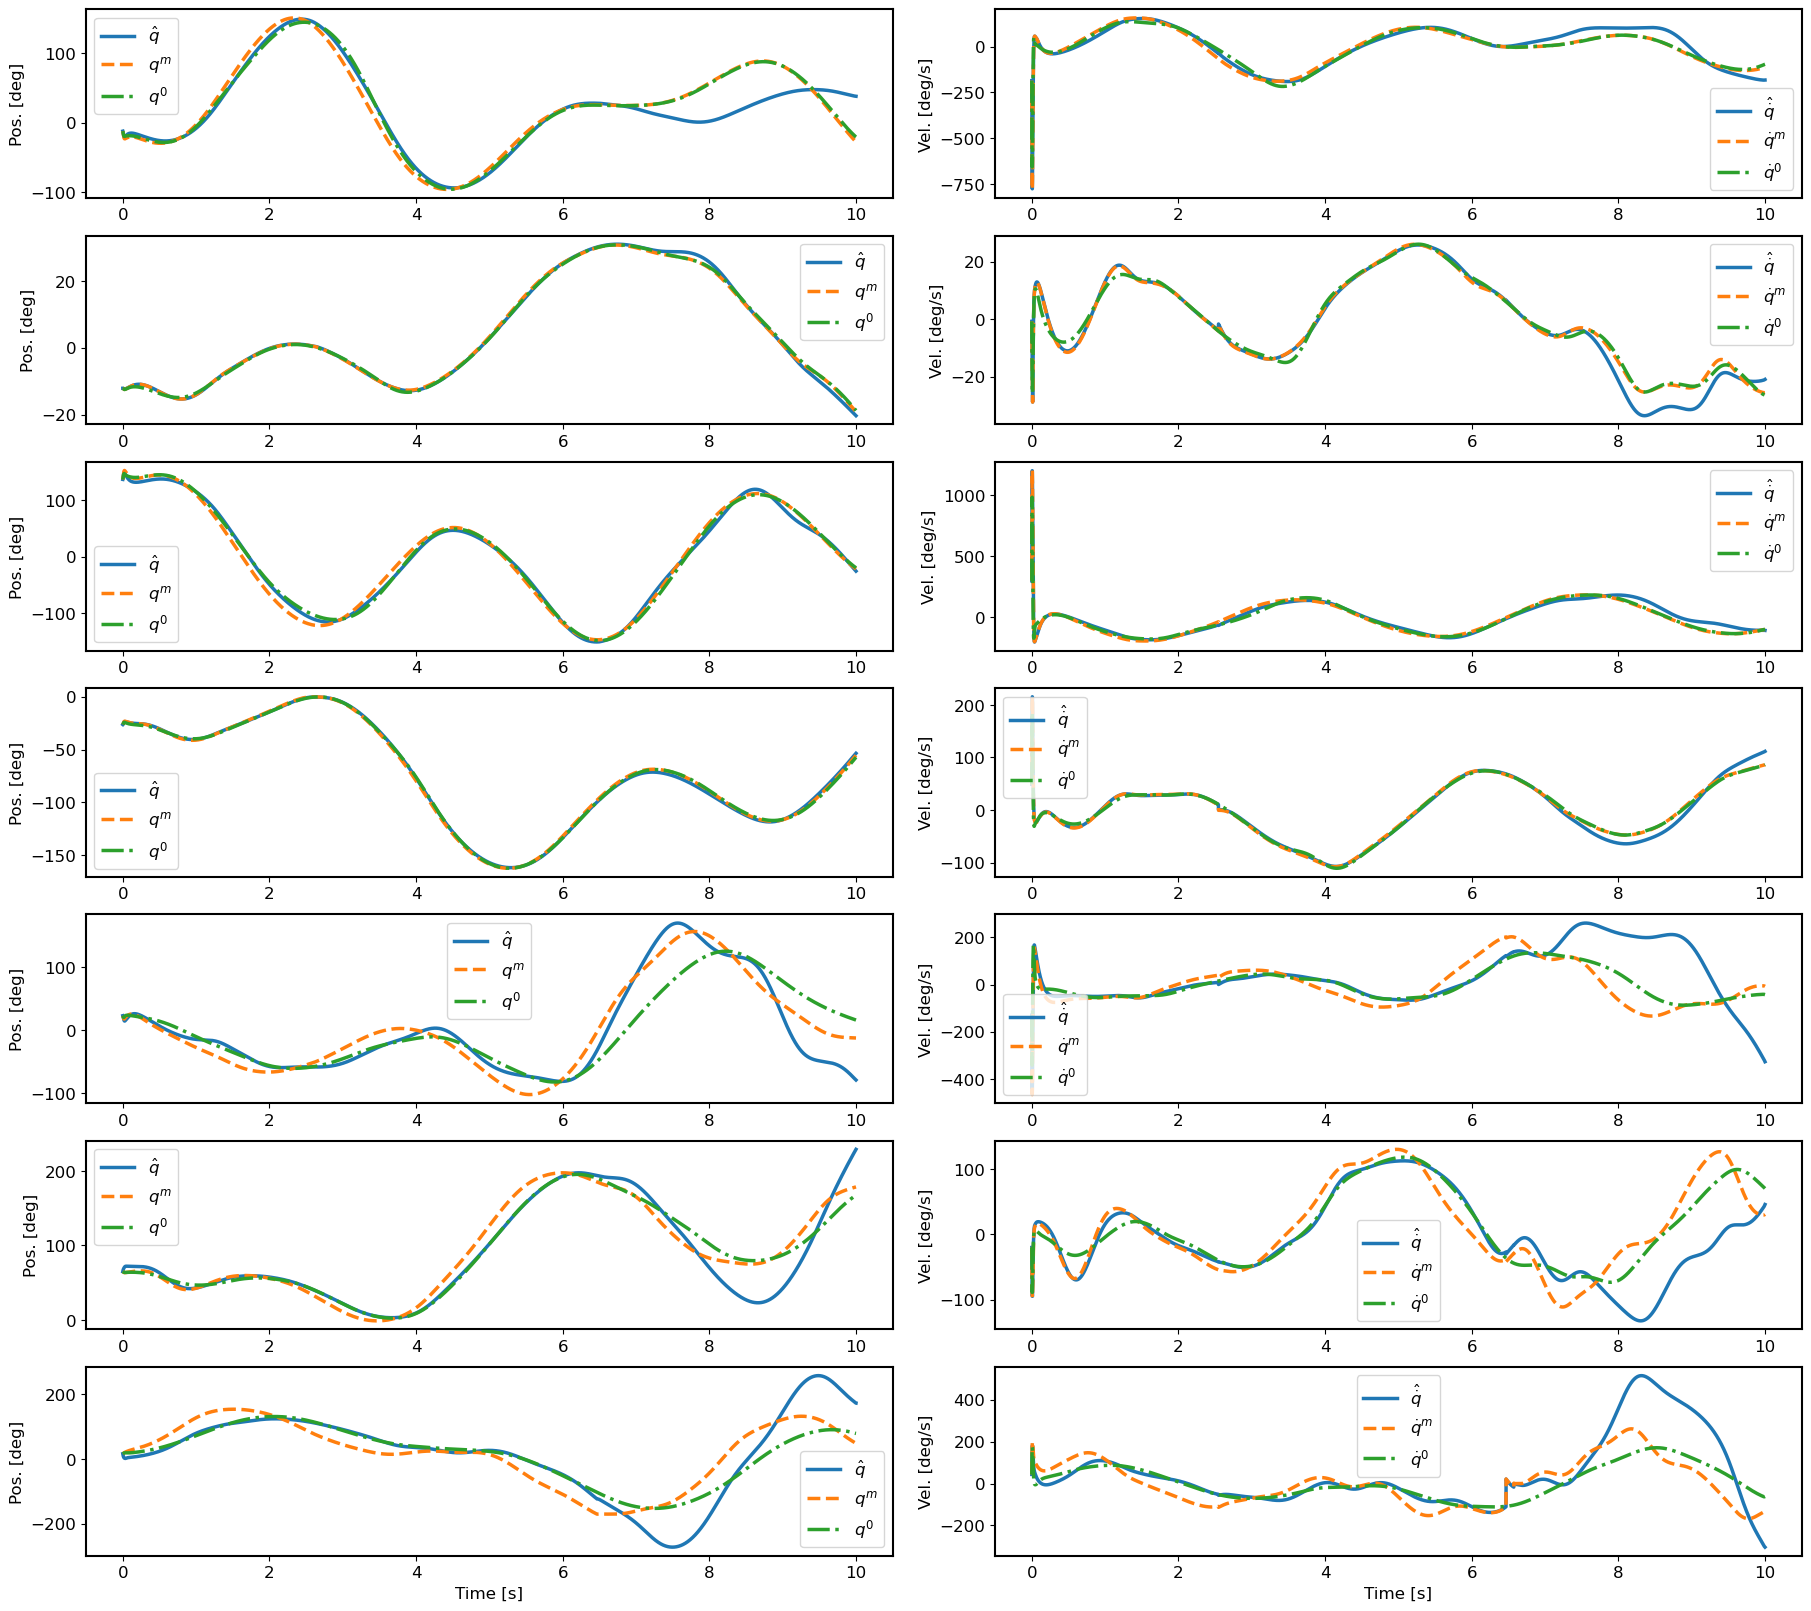

In [45]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(7, 2, constrained_layout = True, figsize=(18,16))

for i in range(7):
    
    ax[i,0].plot(pandaRobot.T[:], rad2deg(pandaRobot.X[traj,i] + model.X_traj[i,:]), label=r'$\hat{q}$')
    ax[i,0].plot(pandaRobot.T[:], rad2deg(pandaRobot.X[traj,i,:]), label=r'$q^m$', linestyle='dashed')
    ax[i,0].plot(pandaRobot.T[:], rad2deg(pandaRobot2.X[traj,i,:]), label=r'$q^0$', linestyle='dashdot')
    ax[i,1].plot(pandaRobot.T[:], rad2deg(pandaRobot.X[traj,7+i] + model.X_traj[7+i,:]), label=r'$\hat{\dot{q}}$')
    ax[i,1].plot(pandaRobot.T[:], rad2deg(pandaRobot.X[traj,7+i,:]), label=r'$\dot{q}^m$', linestyle='dashed')
    ax[i,1].plot(pandaRobot.T[:], rad2deg(pandaRobot2.X[traj,7+i,:]), label=r'$\dot{q}^0$', linestyle='dashdot')
    ax[i,0].set_ylabel('Pos. [deg]'), ax[i,1].set_ylabel('Vel. [deg/s]')
    ax[i,0].legend(), ax[i,1].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

### Apply LQR planner onto real robot dynamics

joints are free now
LQR RMSE : tensor(95.4584, dtype=torch.float64)


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

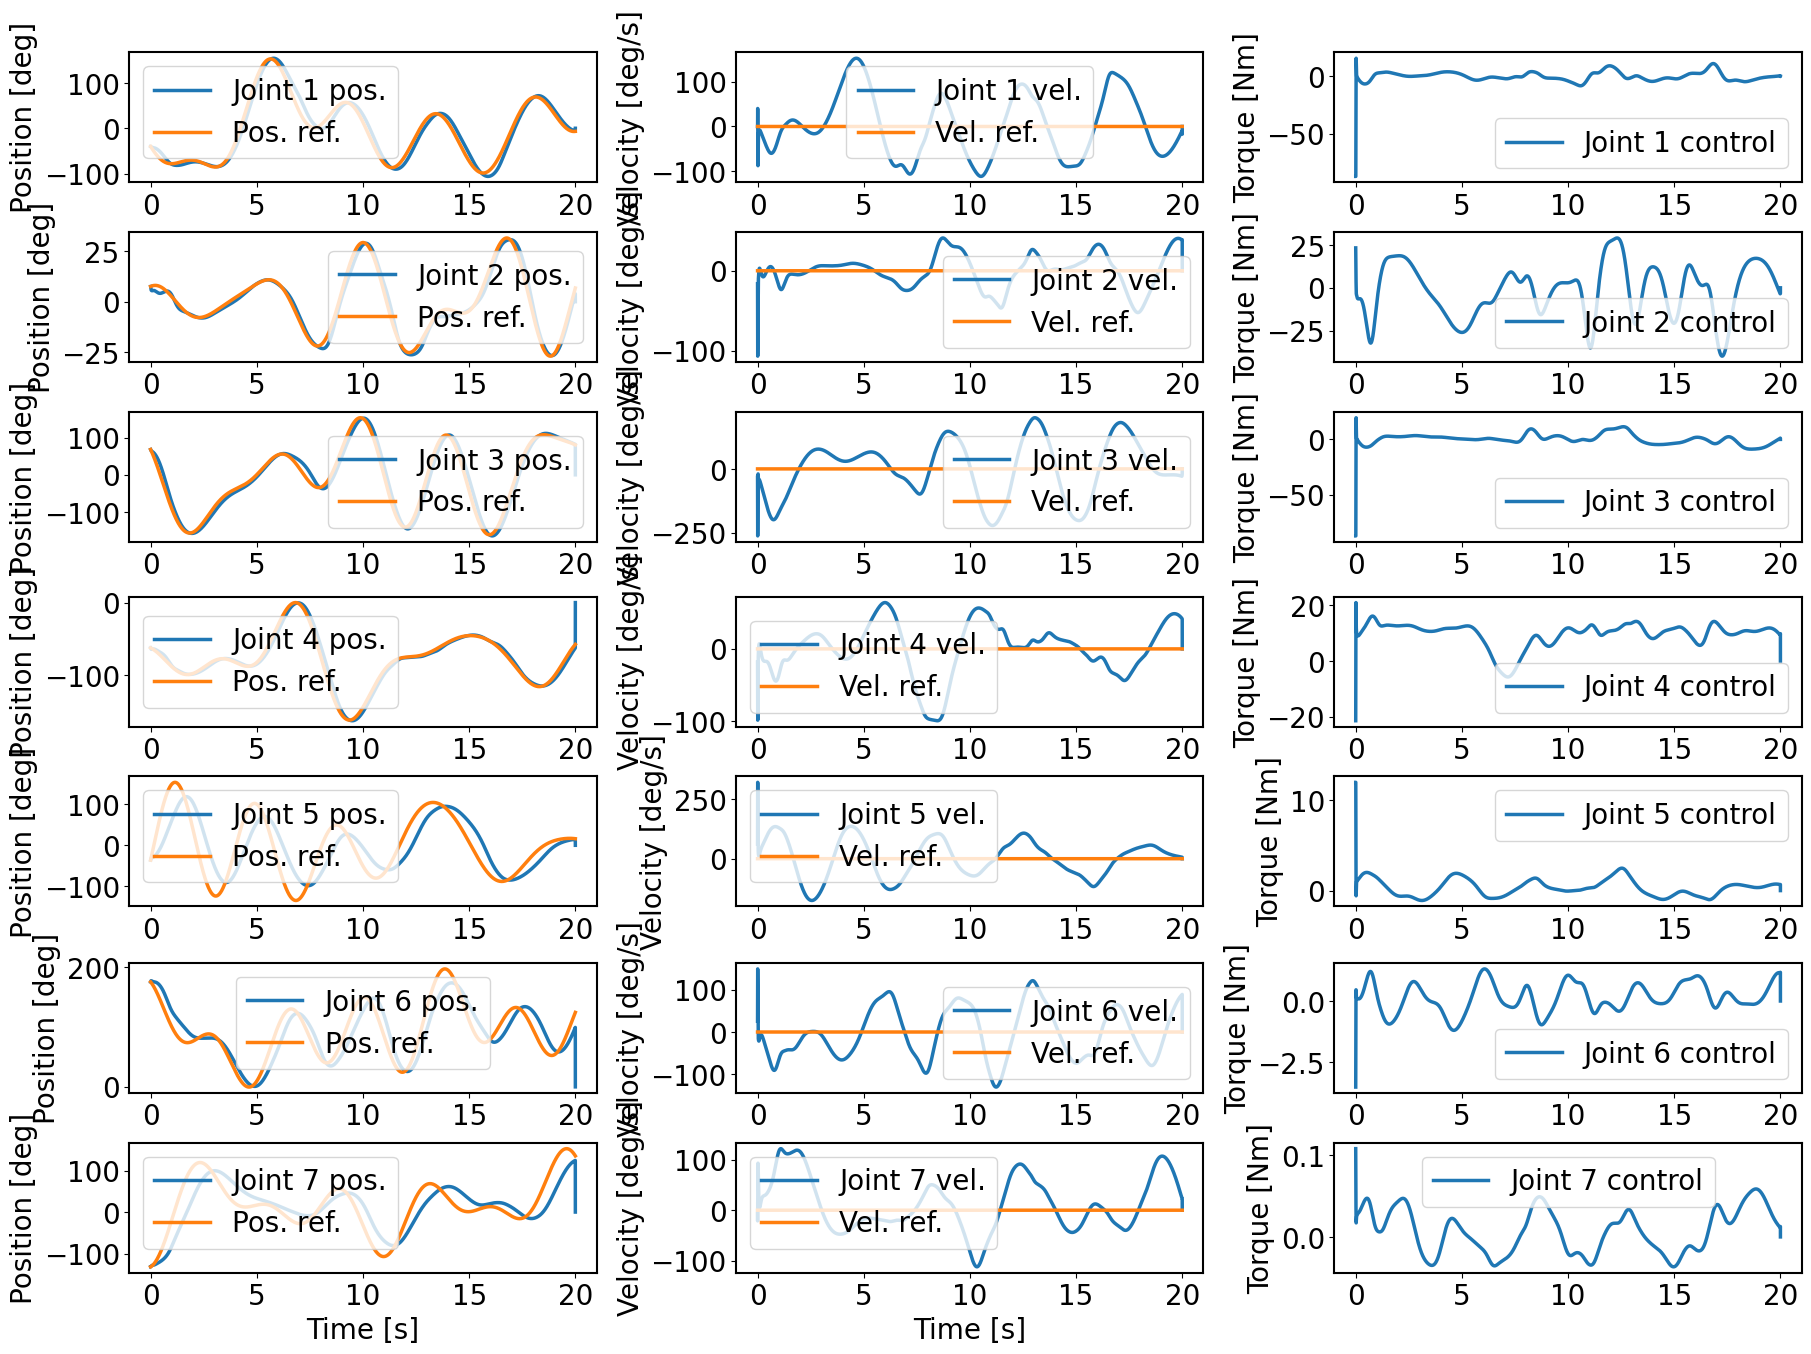

In [124]:
X0 = pandaRobot.ref[traj,:,0]
Xc, Yc = np.zeros(shape=[model.nb_S,model.N]), np.zeros(shape=[model.tau,model.N])
Uc = np.empty(shape=[model.nb_U,model.N-1])

# Initial condition
Xc[:,0] = X0
# N = np.eye(model.tau) - pinv(model.C) @ model.C
Y0 = pinv(model.C)@X0
# Y0 = Y0 + N@(model.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

robot.default_q = Xc[:7,0]
robot.reset_q(max_iter=100)
robot.joints_free=True

sum_error = np.zeros(7)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model.N-2):
    error_q = pandaRobot.ref[traj,:7,i] - robot.q
    error_dq = pandaRobot.ref[traj,7:,i] - robot.dq

#   Computed Torque Control
    control_input = configuration_ctc(Kp @ error_q + Ki @ sum_error + Kd @ error_dq + pandaRobot.desired_ddq[traj,:,i],
                                     robot)
#     PID Control + Feedforward term 
#         control_input = robot.inverse_dynamics(pandaRobot.desired_ddq[n,:,i]) + Kp @ error_q + Ki @ sum_error + Kd @ error_dq
#         control_input = Kp @ error_q + Ki @ sum_error + Kd @ error_dq

    for j in range(7):
        if control_input[j] < robot.joint_torque_limits[j,0]:
            control_input[j] = robot.joint_torque_limits[j,0].copy()
        if control_input[j] > robot.joint_torque_limits[j,1]:
            control_input[j] = robot.joint_torque_limits[j,1].copy()

#   LQR planner control input
    input_correction = model.LQR.get_command(model.pinvC@(Xc[:,i] - pandaRobot.X[traj,:,i].numpy()),i)

    robot.set_torque(control_input[:7] - F_v@robot.dq )

    log_error.append(np.copy(error_q))
    Xc[0:7,i] = robot.q
    Xc[7:,i] = robot.dq
#     log_ddq[n,:,i] = robot.ddq
    Uc[:,i] = np.copy(control_input)
#     time.sleep(dt) # Real-time rendering
    sum_error += error_q*dt
    
    Yc[:,i+1] = pinv(model.C)@Xc[:,i+1]
    
loss_LQR_true = model.RMSE(X_pred=torch.tensor(Xc), 
                                    X_true=torch.tensor(pandaRobot.ref[traj,:,:]))
print('LQR RMSE : '+str(loss_LQR_true))
    
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(7, 3, constrained_layout = True, figsize=(18,13))

for i in range(7):
    
    ax[i,0].plot(pandaRobot.T, rad2deg(Xc[i,:]), label='Joint '+str(i+1)+' pos.')
    ax[i,0].plot(pandaRobot.T, rad2deg(pandaRobot.ref[traj,i,:]), label='Pos. ref.')
    ax[i,1].plot(pandaRobot.T, rad2deg(Xc[i+7,:]), label='Joint '+str(i+1)+' vel.')
    ax[i,1].plot(pandaRobot.T, rad2deg(pandaRobot.ref[traj,i+7,:]), label='Vel. ref.')
    ax[i,2].plot(pandaRobot.T[:len(pandaRobot.T)-1], Uc[i,:], label='Joint '+str(i+1)+' control')
    
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]')
    ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

In [44]:
print(Xc[:,0],pandaRobot.ref[traj,:,0])

[ 1.92311 -0.84735  1.12334 -1.5787   1.15286 -0.00617 -1.87547  0.32676
 -0.18946 -0.40925 -0.64609  0.71115 -0.24451 -1.27567] [-1.00575 -0.67185  1.75852 -0.44156 -1.78396  1.44367  0.94552  0.
  0.       0.       0.       0.       0.       0.     ]
